## Контекст
Подберите базовую модель для работы по вашей задаче. Попробуйте обучить различные модели на «ваших» данных. По результатам выберите лучшую модель для дальнейшего обучения.

## Задание
Проведите эксперименты по начальному обучению различных моделей и сравните результаты.

1.   Возьмите датасет EMNIST из torchvision.
2.   Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161:
*   желательно обучить каждую модель с нуля по 10 эпох
*   если ресурсов компьютера / Colab не хватает, достаточно обучить каждую модель по 1-2 эпохи
3.   Сведите результаты обучения моделей (графики лосса) в таблицу и сравните их.


## 0. Подготовка данных

In [1]:
#импортируем пакеты для работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch
from torch import nn
import torchvision as tv
from torchvision.datasets import EMNIST
from torchsummary import summary
import time

In [2]:
#определим приоритет для обработки на GPU
"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
"""

"\ndevice = 'cuda' if torch.cuda.is_available() else 'cpu'\ndevice\n"

In [2]:
#определим в приоритет mps для macos
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS device found!')
else:
    print('MPS device not found.')
    device = torch.device('cpu')

MPS device found!


In [3]:
#загрузим данные и создадим обучаемый (train) и верификационный (test) датасеты из EMNIST
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.MNIST('.', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=transoforms, download=True)

#создадим итерационные датасеты для обучения и верификации
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=None)

In [4]:
#посмотрим на результат
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [5]:
#посмотрим на результат
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [6]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

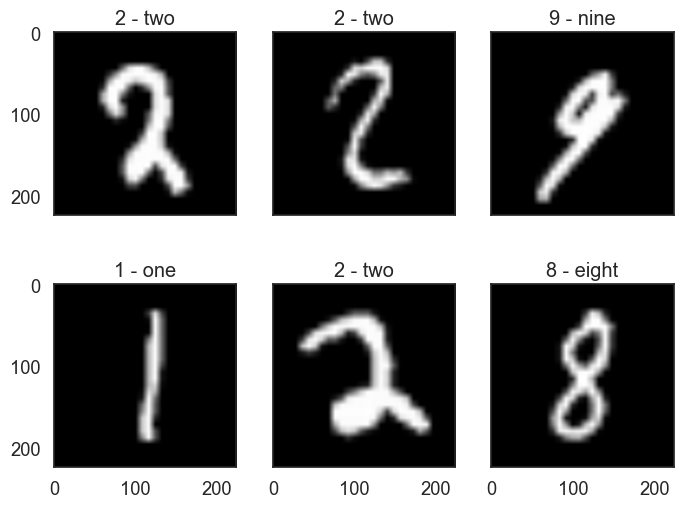

In [7]:
#посмотрим содержимое датасетов
sns.set(style='white', font_scale=1.2)
show_images(train_dataset)

In [8]:
#опишем функцию оценки точности
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [9]:
#опишем функцию обучения модели
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)                                                          #переносим нейросеть на нужное устройство (GPU)
    loss = nn.CrossEntropyLoss(reduction='sum')                             #классифицируем потери, которые считаем (лучше подходит многоклассовая кроссэнтропия с суммированием ошибки)
    net.train()                                                             #вызываем функцию одучения сети

    train_loss = []
    for epoch in range(num_epochs):                                         #запускаем цикл по количеству эпох обучения
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()     #зануляем данные по сумме потерь, сумме метрик точности, количеству шагов, потраченному времени

        for i, (X, y) in enumerate(train_iter):                             #для каждой строки в итерационном датасете
            X, y = X.to(device), y.to(device)                               #переносим картинку и предсказание на устройство
            y_hat = net(X)                                                  #предсказываем y по x
            l = loss(y_hat, y)                                              #высчитываем потери
            l.backward()                                                    #осуществляем градиентный спуск
            trainer.step()                                                  #переходим к следующему шагу
            trainer.zero_grad()                                             #занулим градиенты, которые будут накапливаться при обучении
            train_l_sum += l.item()                                         #суммируем число потерь
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")

        test_acc = evaluate_accuracy(test_iter, net.to(device))
        train_loss.append((train_l_sum / n))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

    return train_loss

# 1. Модель ResNet-18 

In [11]:
#загрузим модель
model = tv.models.resnet18(weights='DEFAULT')

In [12]:
#посмотрим результат
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [14]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [15]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [16]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [17]:
#обучим модель
loss_rn18=train(model, train_iter, test_iter, trainer, 3)
print(f'Потери в ResNet-18: {loss_rn18}')

#сохраним результат в csv-файл  
df = pd.DataFrame(loss_rn18)  

df.to_csv('loss_rn18.csv', index=False)  

Step 0. time since epoch: 0.720. Train acc: 0.078. Train Loss: 2.494
Step 10. time since epoch: 6.598. Train acc: 0.295. Train Loss: 2.101
Step 20. time since epoch: 12.477. Train acc: 0.466. Train Loss: 1.832
Step 30. time since epoch: 18.351. Train acc: 0.563. Train Loss: 1.624
Step 40. time since epoch: 24.295. Train acc: 0.627. Train Loss: 1.458
Step 50. time since epoch: 30.237. Train acc: 0.675. Train Loss: 1.321
Step 60. time since epoch: 36.198. Train acc: 0.707. Train Loss: 1.217
Step 70. time since epoch: 42.151. Train acc: 0.732. Train Loss: 1.129
Step 80. time since epoch: 48.080. Train acc: 0.753. Train Loss: 1.055
Step 90. time since epoch: 54.028. Train acc: 0.769. Train Loss: 0.994
Step 100. time since epoch: 59.921. Train acc: 0.781. Train Loss: 0.943
Step 110. time since epoch: 65.843. Train acc: 0.793. Train Loss: 0.897
Step 120. time since epoch: 71.742. Train acc: 0.803. Train Loss: 0.857
Step 130. time since epoch: 77.677. Train acc: 0.812. Train Loss: 0.821
Step 

# 2. Модель VGG-16 

In [18]:
#загрузим модель
model = tv.models.vgg16(weights='DEFAULT')

In [19]:
#посмотрим результат
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False


In [21]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)

In [22]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [23]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [24]:
#обучим модель
loss_vgg16=train(model, train_iter, test_iter, trainer, 2)
print(f'Потери в VGG-16: {loss_vgg16}')

#сохраним результат в csv-файл  
df = pd.DataFrame(loss_vgg16)  

df.to_csv('loss_vgg16.csv', index=False)  

Step 0. time since epoch: 3.323. Train acc: 0.137. Train Loss: 2.336
Step 10. time since epoch: 28.680. Train acc: 0.440. Train Loss: 1.773
Step 20. time since epoch: 54.533. Train acc: 0.573. Train Loss: 1.463
Step 30. time since epoch: 79.253. Train acc: 0.642. Train Loss: 1.265
Step 40. time since epoch: 104.007. Train acc: 0.679. Train Loss: 1.143
Step 50. time since epoch: 128.790. Train acc: 0.707. Train Loss: 1.049
Step 60. time since epoch: 153.565. Train acc: 0.729. Train Loss: 0.975
Step 70. time since epoch: 178.478. Train acc: 0.745. Train Loss: 0.917
Step 80. time since epoch: 203.287. Train acc: 0.758. Train Loss: 0.870
Step 90. time since epoch: 228.149. Train acc: 0.767. Train Loss: 0.832
Step 100. time since epoch: 253.225. Train acc: 0.775. Train Loss: 0.801
Step 110. time since epoch: 278.414. Train acc: 0.783. Train Loss: 0.771
Step 120. time since epoch: 303.533. Train acc: 0.790. Train Loss: 0.745
Step 130. time since epoch: 328.516. Train acc: 0.795. Train Loss: 

# 3. Модель DenseNet

In [25]:
#загрузим модель
model = tv.models.densenet161(weights='DEFAULT')

In [26]:
#посмотрим результат
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [27]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [28]:
model.classifier = nn.Linear(in_features=2208, out_features=10)

In [29]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [30]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [31]:
#обучим модель
loss_densenet161=train(model, train_iter, test_iter, trainer, 1)
print(f'Потери в Densenet 161: {loss_densenet161}')

#сохраним результат в csv-файл  
df = pd.DataFrame(loss_densenet161)  

df.to_csv('loss_densenet161.csv', index=False)  

Step 0. time since epoch: 7.940. Train acc: 0.051. Train Loss: 2.385
Step 10. time since epoch: 113.778. Train acc: 0.387. Train Loss: 2.031
Step 20. time since epoch: 210.528. Train acc: 0.560. Train Loss: 1.742
Step 30. time since epoch: 300.923. Train acc: 0.647. Train Loss: 1.520
Step 40. time since epoch: 396.880. Train acc: 0.694. Train Loss: 1.361
Step 50. time since epoch: 477.808. Train acc: 0.726. Train Loss: 1.236
Step 60. time since epoch: 553.774. Train acc: 0.748. Train Loss: 1.145
Step 70. time since epoch: 631.663. Train acc: 0.765. Train Loss: 1.069
Step 80. time since epoch: 717.604. Train acc: 0.779. Train Loss: 1.004
Step 90. time since epoch: 798.047. Train acc: 0.790. Train Loss: 0.952
Step 100. time since epoch: 869.633. Train acc: 0.800. Train Loss: 0.906
Step 110. time since epoch: 955.110. Train acc: 0.810. Train Loss: 0.864
Step 120. time since epoch: 1044.179. Train acc: 0.817. Train Loss: 0.827
Step 130. time since epoch: 1122.808. Train acc: 0.824. Train L

# 4. Модель Inception

In [10]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
model = tv.models.inception_v3(weights='DEFAULT')

In [12]:
model = model.to(device)

In [13]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat.argmax(axis=1) == y).sum()
        n += y.shape[0]
        return 0
    return acc_sum.item() / n

In [14]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [15]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=2048, out_features=10)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


In [16]:
#обучим модель
trainer = torch.optim.Adam(params_to_update, lr=0.001)
loss_inc3=train(model, train_iter, test_iter, trainer, 1)
print(f'Потери в Inception v3: {loss_inc3}')

#сохраним результат в csv-файл  
df = pd.DataFrame(loss_inc3)  

df.to_csv('loss_inc3.csv', index=False)

Step 0. time since epoch: 2.186. Train acc: 0.164. Train Loss: 2.259
Step 10. time since epoch: 22.458. Train acc: 0.298. Train Loss: 2.085
Step 20. time since epoch: 42.736. Train acc: 0.424. Train Loss: 1.901
Step 30. time since epoch: 63.003. Train acc: 0.504. Train Loss: 1.744
Step 40. time since epoch: 83.331. Train acc: 0.562. Train Loss: 1.611
Step 50. time since epoch: 103.643. Train acc: 0.597. Train Loss: 1.508
Step 60. time since epoch: 123.843. Train acc: 0.622. Train Loss: 1.426
Step 70. time since epoch: 144.070. Train acc: 0.641. Train Loss: 1.357
Step 80. time since epoch: 164.340. Train acc: 0.658. Train Loss: 1.298
Step 90. time since epoch: 184.669. Train acc: 0.674. Train Loss: 1.244
Step 100. time since epoch: 205.115. Train acc: 0.686. Train Loss: 1.198
Step 110. time since epoch: 225.583. Train acc: 0.696. Train Loss: 1.159
Step 120. time since epoch: 246.045. Train acc: 0.705. Train Loss: 1.124
Step 130. time since epoch: 266.556. Train acc: 0.714. Train Loss: 1

# 5. Сравнение 

In [17]:
df = pd.concat(
    map(pd.read_csv, ['loss_rn18.csv', 'loss_vgg16.csv', 'loss_densenet161.csv', 'loss_inc3.csv']), axis=1)
df.columns = ['loss_rn18', 'loss_vgg16', 'loss_densenet161', 'loss_inc3']
print(df)

   loss_rn18  loss_vgg16  loss_densenet161  loss_inc3
0   0.602000    0.590630          0.594444   0.887002
1   0.222313    0.237365               NaN        NaN
2   0.170717         NaN               NaN        NaN


## Выводы:
1. Почти все модели имеют одинаковые показатели уже после обучения на 1 эпохе, кроме Inception V3, показатели которого хуже остальных
2. По времени дообучения модели различаются значительно; самая быстрая по обучению - ResNet18
3. В качестве основной необходимо брать модель ResNet18.